# Compare Data
Look at the differences between different Data files

In [2]:
import sys
import os

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../../'))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from Components import data_loader


## Compare Simulated vs Simulated Data

from the Forward Simulation

In [3]:
file_list = ["../../Debug Data/Demo Data/Forward Simulation Outputs/Sample_Data_000.pt",
            "../../Debug Data/Demo Data/Forward Simulation Outputs/Sample_Data_001.pt"
            ]
                 
    
dataset = data_loader.SimDataset(file_list = file_list)
sample_1 = dataset[0]
sample_2 = dataset[1]

print("Comparing: ")
print(f"   {sample_1.file_path}")
print(f"   {sample_2.file_path}")

field_1 = sample_1.field.detach().clone()
field_2 = sample_2.field.detach().clone()

field_1 = field_1.to("cpu")
field_2 = field_2.to("cpu")

FileNotFoundError: [Errno 2] No such file or directory: '../../Debug Data/Demo Data/Forward Simulation Outputs/Sample_Data_000.pt'

General wavefield

In [14]:
print("Field Shapes:")
print(f"    {field_1.shape}")
print(f"    {field_1.shape}")
print()

print("Field Data Types:")
print(f"    {field_1.dtype}")
print(f"    {field_1.dtype}")
print()

print("Field L2 norm difference:", torch.linalg.norm(field_1 - field_2))
print("Relative field error:", torch.linalg.norm(field_1 - field_2) / torch.linalg.norm(field_1))
    

Field Shapes:
    torch.Size([250, 250])
    torch.Size([250, 250])

Field Data Types:
    torch.complex128
    torch.complex128

Field L2 norm difference: tensor(0., dtype=torch.float64)
Relative field error: tensor(0., dtype=torch.float64)


Intensities

 Min/Max Intensity:
   0.9999999999999998, 1.0
   0.9999999999999998, 1.0

 Max Intensity difference:
   0.0



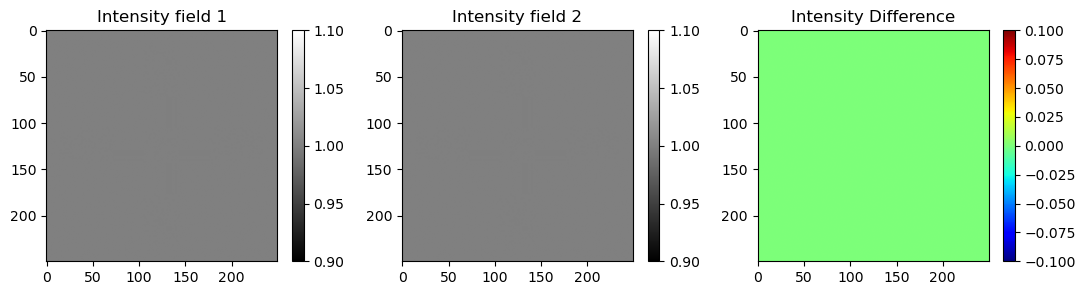

In [15]:
intensity_img_1 = torch.abs(field_1)**2 
intensity_img_2 = torch.abs(field_2)**2 

print(" Min/Max Intensity:")
print(f"   {torch.min(intensity_img_1)}, {torch.max(intensity_img_1)}")
print(f"   {torch.min(intensity_img_2)}, {torch.max(intensity_img_2)}")
print()


intensity_diff = torch.abs(intensity_img_1-intensity_img_2) 
print(" Max Intensity difference:")
print(f"   {torch.max(intensity_diff)}")
print()


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(intensity_img_1.T, cmap='gray')
img2 = ax2.imshow(intensity_img_2.T, cmap='gray')
img3 = ax3.imshow(intensity_diff.T, cmap='jet')

ax1.set_title("Intensity field 1")    
ax2.set_title("Intensity field 2")
ax3.set_title("Intensity Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()

Phase

 Min/Max Phase:
   -2.5953990041424975, -2.5951430943099654
   -2.5953990041424975, -2.5951430943099654

 Max Phase difference:
   0.0



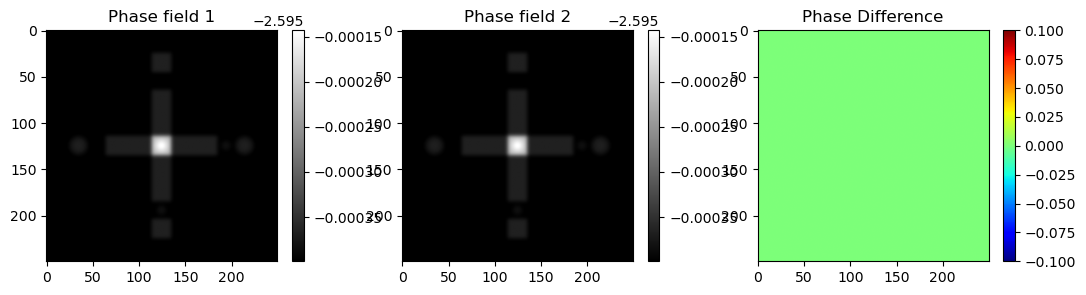

In [16]:
phase_img_1 = torch.angle(field_1)
phase_img_2 = torch.angle(field_2)

#phase_img_1 = torch.from_numpy(unwrap_phase(phase_img_1))
#phase_img_2 = torch.from_numpy(unwrap_phase(phase_img_2))

print(" Min/Max Phase:")
print(f"   {torch.min(phase_img_1)}, {torch.max(phase_img_1)}")
print(f"   {torch.min(phase_img_2)}, {torch.max(phase_img_2)}")
print()


phase_diff = torch.abs(phase_img_1-phase_img_2) 
print(" Max Phase difference:")
print(f"   {torch.max(phase_diff)}")
print()

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(phase_img_1.T, cmap='gray')
img2 = ax2.imshow(phase_img_2.T, cmap='gray')
img3 = ax3.imshow(phase_diff.T, cmap='jet')

ax1.set_title("Phase field 1")    
ax2.set_title("Phase field 2")
ax3.set_title("Phase Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()

## Compare Simulated Data to DHM GT Data

Forward Simulation vs. Real Data

In [ ]:
sim_data_path = ["../../Debug Data/Demo Data/Forward Simulation Outputs/Sample_Data_000.pt"]
recored_data_path = ["../../Debug Data/Demo Data/DHM GT Data/DHM_000.pt"]

sim_dataset = data_loader.SimDataset(file_list=sim_data_path, device=torch.device("cpu"))
rec_dataset = data_loader.FrameDataset(file_list=recored_data_path, device=torch.device("cpu"))

sim_data = sim_dataset[0]
rec_data = rec_dataset[0]



Process simulation data to fit DHM GT Data

In [51]:

# Simulation Data
sim_data_field = sim_data.field
sim_supp = torch.tensor([5e-5,5e-5,5e-5])


# Crop to 250x250
sim_data_field = sim_data_field[125:-125, 125:-125]


# Convert to real and imaginary parts
real = sim_data_field.real
imag = sim_data_field.imag

# Stack into a 2-channel tensor and add batch dimension
field_tensor = torch.stack([real, imag], dim=0).unsqueeze(0)  # shape: (1, 2, 250, 250)

# Interpolate back to 500x500
upsampled = F.interpolate(field_tensor, size=(500, 500), mode='bilinear', align_corners=False)  # shape: (1, 2, 500, 500)

# Remove batch dimension and convert back to complex
upsampled = upsampled.squeeze(0)
sim_data_field = upsampled[0] + 1j * upsampled[1]  

sim_supp = sim_supp/ 2



# recorded data
#rec_data_field = rec_data.field
rec_supp = torch.tensor([5e-5,5e-5,5e-5]) / 2

Intensity

 Sim | Recorded Data
   Min: 0.25440001487731934 | 0.0864
   Max: 2.1738998889923096 | 2.9605
   Mean: 0.9987999796867371 | 1.0224
   Std: 0.2395000010728836 | 0.2648


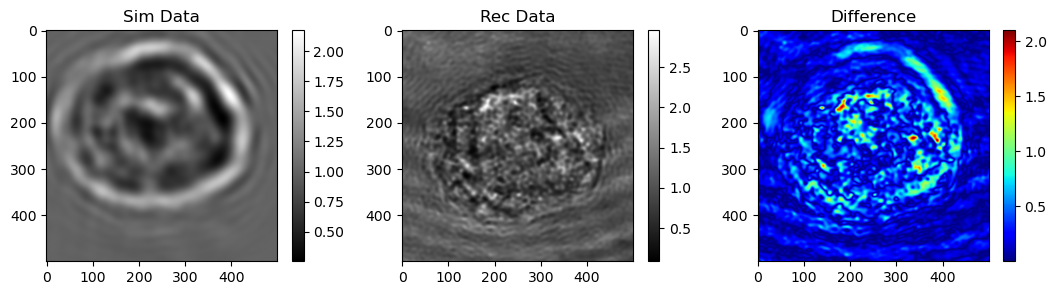

In [54]:
sim_intensity = torch.abs(sim_data_field)**2
rec_intensity = rec_data.amp

sim_intensity = sim_intensity.detach().cpu().numpy()
rec_intensity = rec_intensity.detach().cpu().numpy()

sim_min = np.round(np.min(sim_intensity), decimals=4)
sim_max = np.round(np.max(sim_intensity), decimals=4)
sim_mean = np.round(np.mean(sim_intensity), decimals=4)
sim_std = np.round(np.std(sim_intensity), decimals=4)

rec_min = np.round(np.min(rec_intensity), decimals=4)
rec_max = np.round(np.max(rec_intensity), decimals=4)
rec_mean = np.round(np.mean(rec_intensity), decimals=4)
rec_std = np.round(np.std(rec_intensity), decimals=4)



print(" Sim | Recorded Data")
print(f"   Min: {sim_min} | {rec_min}")
print(f"   Max: {sim_max} | {rec_max}")
print(f"   Mean: {sim_mean} | {rec_mean}")
print(f"   Std: {sim_std} | {rec_std}")


intensity_diff = np.abs(sim_intensity-rec_intensity) 
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(sim_intensity.T, cmap='gray')
img2 = ax2.imshow(rec_intensity.T, cmap='gray')
img3 = ax3.imshow(intensity_diff.T, cmap='jet')

ax1.set_title("Sim Data")    
ax2.set_title("Rec Data")
ax3.set_title("Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()

Phase

 Sim | Recorded Data
   Min: -2.8164000511169434 | -0.4277
   Max: 2.361599922180176 | 4.3226
   Mean: -1.6871000528335571 | 0.724
   Std: 1.2865999937057495 | 1.28


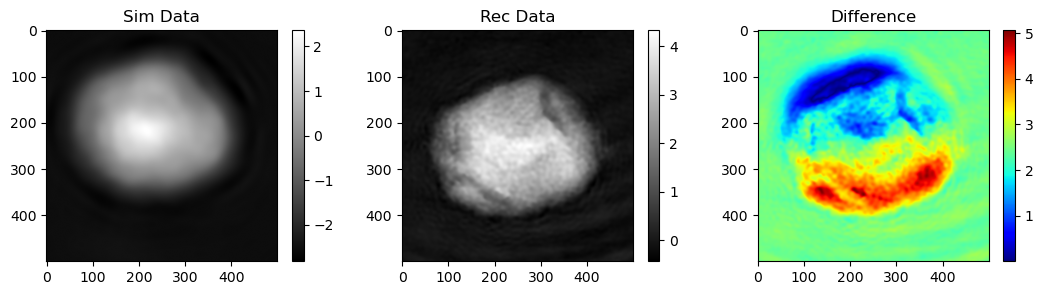

In [55]:
sim_phase = torch.angle(sim_data_field)
rec_phase = (2*torch.pi) / (640e-9 / 1e-6)  * rec_data.opd 

sim_phase = sim_phase.detach().cpu().numpy()
rec_phase = rec_phase.detach().cpu().numpy()

sim_min = np.round(np.min(sim_phase), decimals=4)
sim_max = np.round(np.max(sim_phase), decimals=4)
sim_mean = np.round(np.mean(sim_phase), decimals=4)
sim_std = np.round(np.std(sim_phase), decimals=4)

rec_min = np.round(np.min(rec_phase), decimals=4)
rec_max = np.round(np.max(rec_phase), decimals=4)
rec_mean = np.round(np.mean(rec_phase), decimals=4)
rec_std = np.round(np.std(rec_phase), decimals=4)


print(" Sim | Recorded Data")
print(f"   Min: {sim_min} | {rec_min}")
print(f"   Max: {sim_max} | {rec_max}")
print(f"   Mean: {sim_mean} | {rec_mean}")
print(f"   Std: {sim_std} | {rec_std}")

phase_diff = np.abs(sim_phase-rec_phase) 
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(sim_phase.T, cmap='gray')
img2 = ax2.imshow(rec_phase.T, cmap='gray')
img3 = ax3.imshow(phase_diff.T, cmap='jet')

ax1.set_title("Sim Data")    
ax2.set_title("Rec Data")
ax3.set_title("Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()

## Compare DHM GT Data vs. DHM GT Data

real data vs real data

In [ ]:

data_paths = ["../../Debug Data/Demo Data/DHM GT Data/DHM_000.pt",
              "../../Debug Data/Demo Data/DHM GT Data/DHM_001.pt"]

dataset = data_loader.FrameDataset(file_list=data_paths, device=torch.device("cpu"))

sample_1 = dataset[0]
sample_2 = dataset[1]

print("Comparing: ")
print(f"   {sample_1.file_path}")
print(f"   {sample_2.file_path}")


Comparing: 
   ../../Debug Data/Demo Data/DHM GT Data/DHM_000.pt
   ../../Debug Data/Demo Data/DHM GT Data/DHM_001.pt


Amplitude

 Min/Max Intensity:
   0.08641871809959412, 2.960521936416626
   0.0892317146062851, 3.0238189697265625

 Max Intensity difference:
   0.33741581439971924


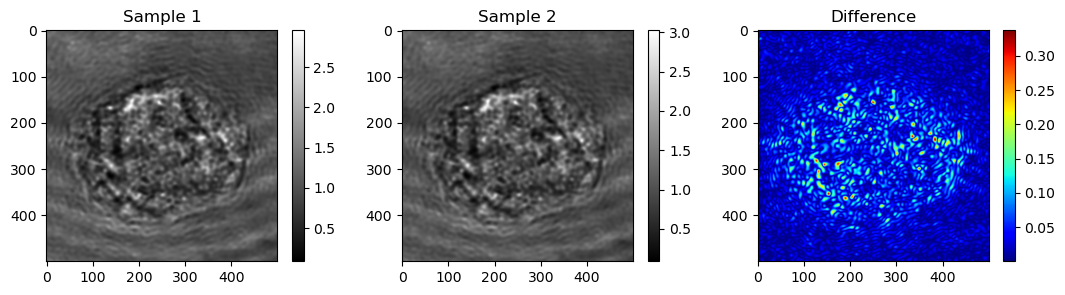

In [ ]:


amp_1 = sample_1.amp.detach().clone().numpy()
amp_2 = sample_2.amp.detach().clone().numpy()

print(" Min/Max Amplitude:")
print(f"   {np.min(amp_1)}, {np.max(amp_1)}")
print(f"   {np.min(amp_2)}, {np.max(amp_2)}")
print()


amp_diff = np.abs(amp_1-amp_2) 
print(" Max Amplitude difference:")
print(f"   {np.max(amp_diff)}")


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(amp_1.T, cmap='gray')
img2 = ax2.imshow(amp_2.T, cmap='gray')
img3 = ax3.imshow(amp_diff.T, cmap='jet')

ax1.set_title("Sample 1")    
ax2.set_title("Sample 2")
ax3.set_title("Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()

Opd

 Min/Max Opd:
   -0.0435608028430112, 0.44029866125622413
   -0.04603387882245626, 0.4396759458744992

 Max Opd difference:
   0.33741581439971924


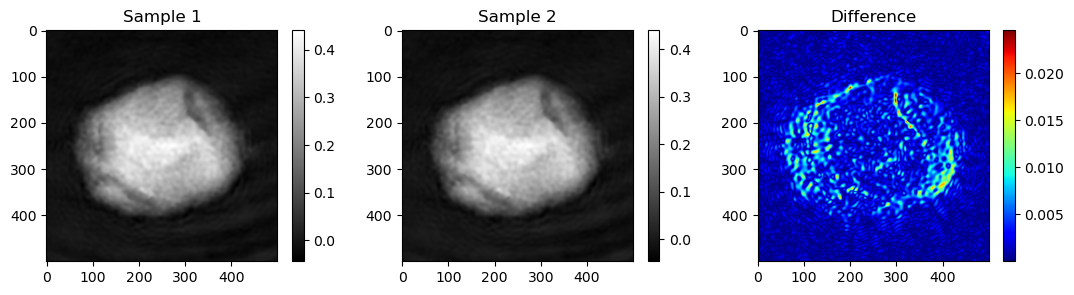

In [61]:

opd_1 = sample_1.opd.detach().clone().numpy()
opd_2 = sample_2.opd.detach().clone().numpy()

print(" Min/Max Opd:")
print(f"   {np.min(opd_1)}, {np.max(opd_1)}")
print(f"   {np.min(opd_2)}, {np.max(opd_2)}")
print()


opd_diff = np.abs(opd_1-opd_2) 
print(" Max Opd difference:")
print(f"   {np.max(amp_diff)}")


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

img1 = ax1.imshow(opd_1.T, cmap='gray')
img2 = ax2.imshow(opd_2.T, cmap='gray')
img3 = ax3.imshow(opd_diff.T, cmap='jet')

ax1.set_title("Sample 1")    
ax2.set_title("Sample 2")
ax3.set_title("Difference")

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)
plt.colorbar(img3, ax=ax3)

plt.show()
plt.close()